# BZNSYP - 创建频谱图数据

音频经过了以下变换：

1. 将音频转换为频谱图
  * `sample_rate` 设置为 `22050`
  * `win_length` 设置为 `512`
  * `hop_length` 设置为 `128`
1. 统一音量大小

文本经过以下变换：

1. 去除了带有儿化音的句子
1. 给拼音添加标点符号
1. 拼音转换成了数字索引

In [ ]:
import os
import re
import json
import datetime
import librosa
import librosa.display
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm

## 挂载 Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 解压数据

数据来自：[标贝科技 - 中文标准女声音库](https://test.data-baker.com/#/data/index/source)

这个必须得手动下载，然后再上传到 `Google Drive` 上


In [ ]:
!unrar x /content/drive/MyDrive/训练数据/语音/BZNSYP/BZNSYP.rar /content > unzip_log.txt

## 读取句子数据

In [ ]:
sentences = dict()

with open('/content/ProsodyLabeling/000001-010000.txt', 'r', encoding='utf-8') as f:
  # 用于去掉句子中的分隔符
  regex = re.compile('#\d')
  
  while True:
    l1 = f.readline()
    l2 = f.readline()
    if len(l1) == 0: break

    name, sentence = l1.split('\t')
    pinyins = l2.strip().split(' ')
    sentence = regex.sub('', sentence.strip())

    sentences[name] = {'pinyins': pinyins, 'sentence': sentence}

## 构建 5 声拼音字典

这个里面只包含训练数据中出现过的发音，缺失的发音用近似的发音来进行替代。

#### 加载拼音表

In [ ]:
!wget https://raw.githubusercontent.com/wu-jingtao/training-data/master/speech_recognition/chinese/拼音字典/phonetic.txt

In [ ]:
with open('phonetic.txt') as f:
  phonetic = f.readlines()
  phonetic = [i.strip() for i in phonetic]

#### 统计句子中出现过的发音

In [ ]:
occurred_pinyin = set()

for item in sentences.values():
  for p in item['pinyins']:
    occurred_pinyin.add(p)

#### 统计句子中出现过的标点符号

In [ ]:
punctuation = set()

for item in sentences.values():
  for p in re.findall('[^ＢＰ\u4e00-\u9fa5]', item['sentence']):
    punctuation.add(p)
      
punctuation

{'—', '“', '”', '…', '、', '。', '！', '（', '）', '，', '：', '；', '？'}

#### 构建拼音字典

In [ ]:
pinyin_mapper = {'count': 0}
missing_pinyin = []

for i in phonetic:
  # 查看训练输出中存在哪几种声调
  exist = [i + str(x) in occurred_pinyin for x in range(1, 6)]

  if any(exist):
    # 确定当缺少某个声调的时候使用哪个声调来进行代替
    base = 4 if exist[4] else\
          0 if exist[0] else\
            1 if exist[1] else\
              2 if exist[2] else\
                3 if exist[3] else -1
    
    base_name = i + str(base + 1)
    pinyin_mapper[base_name] = pinyin_mapper['count']
    pinyin_mapper[pinyin_mapper['count']] = base_name
    pinyin_mapper['count'] += 1

    for j, k in enumerate(exist):
      if j != base:
        name = i + str(j + 1)
        if k:
          pinyin_mapper[name] = pinyin_mapper['count']
          pinyin_mapper[pinyin_mapper['count']] = name
          pinyin_mapper['count'] += 1
        else:
          pinyin_mapper[name] = pinyin_mapper[base_name]
  else:
    missing_pinyin.append(i)

print('发音类别总数：', pinyin_mapper['count'])

发音类别总数： 1535


#### 补全缺失的拼音

缺失的拼音

In [ ]:
missing_pinyin

['chua', 'den', 'eng', 'lue', 'm', 'nou', 'nun']

要用于替代的拼音

In [ ]:
replace_pinyin = ['chuan', 'deng', 'neng', 'lve', 'meng', 'niu', 'nu']

In [ ]:
for missing, replace in zip(missing_pinyin, replace_pinyin):
  for i in range(1, 6):
    pinyin_mapper[missing + str(i)] = pinyin_mapper[replace + '5']

#### 添加标点符号

In [ ]:
for item in punctuation:
  pinyin_mapper[item] = pinyin_mapper['count']
  pinyin_mapper[pinyin_mapper['count']] = item
  pinyin_mapper['count'] += 1

## 去除包含儿化音的句子

In [ ]:
for key, value in sentences.copy().items():
  if any([i not in pinyin_mapper for i in value['pinyins']]):
    del sentences[key]

print('不包含儿化音的句子有：', len(sentences))

不包含儿化音的句子有： 9773


## 给拼音添加标点符号

In [ ]:
regex = re.compile(f'[{"".join(punctuation)}]')

for item in sentences.values():
  start = 0
  add_punctuation = 0
  result = []
  for p in regex.finditer(item['sentence']):
    end = p.start() - add_punctuation
    result += item['pinyins'][start:end]
    result.append(p.group())
    start = end
    add_punctuation += 1
  item['pinyins_punctuation'] = result

查看效果

In [ ]:
item = sentences['002794']
print('sentence：', item['sentence'])
print('pinyins：', item['pinyins'])
print('pinyins_punctuation：', item['pinyins_punctuation'])

sentence： 海边、沙滩，还有吃海鲜呀。
pinyins： ['hai3', 'bian1', 'sha1', 'tan1', 'hai2', 'you3', 'chi1', 'hai3', 'xian1', 'ya5']
pinyins_punctuation： ['hai3', 'bian1', '、', 'sha1', 'tan1', '，', 'hai2', 'you3', 'chi1', 'hai3', 'xian1', 'ya5', '。']


添加标点符号后句子的最大长度

In [ ]:
max([len(item['pinyins_punctuation']) for item in sentences.values()])

37

## 处理音频数据

In [ ]:
def load_audio():
  for name in sentences.keys():
    audio, sr = librosa.load(f'Wave/{name}.wav', sr=22050)
    stft = librosa.stft(audio, n_fft=512, hop_length=128)
    # 转换为频谱图，顺便统一音量
    magnitude = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    # 将取值范围调整到 [-1, 1] 之间
    magnitude = (magnitude + 40) / 40
    yield magnitude.T

In [ ]:
audios = tf.data.Dataset.from_generator(load_audio, output_signature=tf.TensorSpec(shape=(None, 257), dtype=tf.float32))

查看效果

In [ ]:
audio = next(iter(audios))

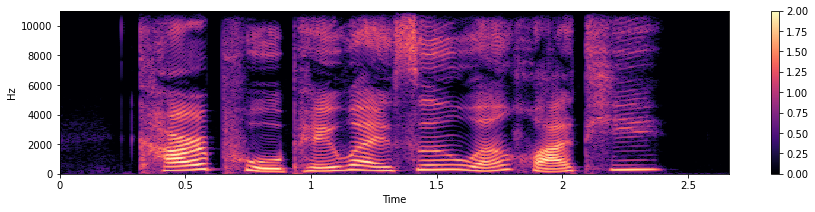

In [ ]:
plt.figure(figsize=(15, 3))
librosa.display.specshow(audio.numpy().T + 1, y_axis='linear', x_axis='time', sr=22050, hop_length=128)
plt.colorbar()

In [ ]:
amplitude = librosa.db_to_amplitude(audio.numpy().T * 40 - 40)
wave = librosa.griffinlim(amplitude, win_length=512, hop_length=128)
ipd.Audio(wave, rate=22050)

## 保存训练数据

#### 保存拼音字典

In [ ]:
with open('pinyin_mapper.json', 'w') as f:
  json.dump(pinyin_mapper, f)

#### 保存句子数据

In [ ]:
def words_generator():
  for item in sentences.values():
    yield list(item['sentence'])

words = tf.data.Dataset.from_generator(words_generator, output_signature=tf.TensorSpec(shape=(None,), dtype=tf.string))
words = words.cache('/content/words')

In [ ]:
with tqdm(total=len(sentences)) as pbar:
  for i in words: pbar.update()

100%|██████████| 9773/9773 [00:03<00:00, 2792.71it/s]


#### 保存拼音数据

In [ ]:
def pinyins_generator():
  for item in sentences.values():
    yield [pinyin_mapper[i] for i in item['pinyins']]

pinyins = tf.data.Dataset.from_generator(pinyins_generator, output_signature=tf.TensorSpec(shape=(None,), dtype=tf.int32))
pinyins = pinyins.cache('/content/pinyins')

In [ ]:
with tqdm(total=len(sentences)) as pbar:
  for i in pinyins: pbar.update()

100%|██████████| 9773/9773 [00:03<00:00, 2793.49it/s]


#### 保存带标点符号拼音数据

In [ ]:
def pinyins_punctuation_generator():
  for item in sentences.values():
    yield [pinyin_mapper[i] for i in item['pinyins_punctuation']]

pinyins_punctuation = tf.data.Dataset.from_generator(pinyins_punctuation_generator, output_signature=tf.TensorSpec(shape=(None,), dtype=tf.int32))
pinyins_punctuation = pinyins_punctuation.cache('/content/pinyins_punctuation')

In [ ]:
with tqdm(total=len(sentences)) as pbar:
  for i in pinyins_punctuation: pbar.update()

100%|██████████| 9773/9773 [00:05<00:00, 1911.07it/s]


#### 保存音频数据

In [ ]:
audios = audios.cache('/content/audios')

In [ ]:
with tqdm(total=len(sentences)) as pbar:
  for i in audios: pbar.update()

100%|██████████| 9773/9773 [35:21<00:00,  4.61it/s]


## 创建说明文件

In [ ]:
readme = '''数据来源：https://test.data-baker.com/#/data/index/source
项目地址：https://github.com/wu-jingtao/training-data/blob/master/speech_synthesis/chinese/BZNSYP/README.md
创建时间：{}

数据类型：
audios：音频对应的频谱图
  {}

words：音频对应的文字
  {}

pinyins：音频对应的拼音
  {}

pinyins_punctuation：音频对应的带标点符号的拼音
  {}

示例代码：
>>> data = tf.data.Dataset.from_generator(lambda: None, output_signature=tf.TensorSpec(shape=(None, 257), dtype=tf.float32))
>>> data = data.cache('文件夹路径/audios')
'''

readme = readme.format(
  datetime.datetime.today(),
  audios.element_spec,
  words.element_spec,
  pinyins.element_spec,
  pinyins_punctuation.element_spec
)

with open('README.txt', 'w') as f:
  f.write(readme)

## 压缩数据

In [ ]:
!7z a BZNSYP_magnitude.7z \
README.txt \
pinyin_mapper.json \
audios.index audios.data-00000-of-00001 \
words.index words.data-00000-of-00001 \
pinyins.index pinyins.data-00000-of-00001 \
pinyins_punctuation.index pinyins_punctuation.data-00000-of-00001 > zip_log.txt

## 上传到 Google Drive

In [ ]:
!cp BZNSYP_magnitude.7z /content/drive/Shareddrives/TeamDrive_top_edu/生成数据/BZNSYP_magnitude.7z

In [ ]:
!mkdir -p /content/drive/Shareddrives/TeamDrive_top_edu/生成数据/BZNSYP_magnitude
!cp \
README.txt \
pinyin_mapper.json \
audios.index audios.data-00000-of-00001 \
words.index words.data-00000-of-00001 \
pinyins.index pinyins.data-00000-of-00001 \
pinyins_punctuation.index pinyins_punctuation.data-00000-of-00001 \
/content/drive/Shareddrives/TeamDrive_top_edu/生成数据/BZNSYP_magnitude